In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sb
import matplotlib

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [3]:
import random

def set_seed(seed=42):
    random.seed(42)
    np.random.seed(seed)
    th.manual_seed(42)

# NTB Model

In [4]:
from Utils.prices import european_call_delta
from Utils.tensors import create_module, clamp, to_numpy

class NoTransactionBand(nn.Module):
    def __init__(self,
                 features_in,
                 net_arch, activation_fn=None, net_kwargs=None, squash = False):
        super(NoTransactionBand, self).__init__()
        mlp = create_module(features_in, 2,
                            net_arch, activation_fn, net_kwargs)
        if squash:
            mlp.append(nn.Tanh())

        self.squash = squash
        self.mlp = nn.Sequential(*mlp)

    def forward(self, obs):
        moneyness, expiry, volatility, prev_hedge = [obs[..., i] for i in range(4)]

        actions = self.mlp(obs)     # [-1, 1]
        delta = european_call_delta(to_numpy(moneyness),
                                    to_numpy(expiry),
                                    to_numpy(volatility))  # [0, 1]
        delta = th.tensor(delta).to(actions)

        lb = delta - F.leaky_relu(actions[..., 0])      # [-1, 1.a]
        ub = delta + F.leaky_relu(actions[..., 1])      # [-1, 1.a]

        hedge = clamp(prev_hedge, lb, ub)
        if self.squash:
            hedge = 0.5*(th.clamp(hedge, -1, 1) + 1.0)      # [0, 1]

        return hedge

    def predict(self, obs):
        return self.forward(obs), None

# Env

env가 geometric_brownian_motion, european_call_delta 로 직접 생성한 데이터와 동일한 데이터를 생성함을 확인하였음

In [5]:
from Env.env_torch import BSMarket, BSMarketEval

env_kwargs = {'n_assets': 1000,
              'cost': 1e-3,
              'payoff_coeff': 0.0}

set_seed()
env = BSMarket(**env_kwargs)

env 'BSMarket was created!


# Compute PNL

In [6]:
from Utils.prices import geometric_brownian_motion, european_call_delta

def to_tensor(ndarray):
    return th.from_numpy(ndarray).to(th.float32)

def compute_pnl(model, n_paths=1000, n_periods=30, volatility=0.2, dt=1/365):
    prices = geometric_brownian_motion(n_paths=n_paths,
                                       n_periods=n_periods,
                                       drift=0.0, volatility=volatility,
                                       init_price=1.0,
                                       dt=dt)

    prices = to_tensor(prices)

    prev_hedge = th.zeros(n_paths)
    total_pnl = 0.0
    cost = 1e-3

    def get_obs(i):
        moneyness = prices[i, :, None]
        expiry = th.full_like(moneyness, (n_periods - i)*dt)
        vol = th.full_like(moneyness, volatility)
        prev_hold = th.clone(prev_hedge).view(moneyness.shape)

        obs = th.cat([moneyness, expiry, vol, prev_hold], dim=1)
        return obs

    for i in range(n_periods - 1):
        obs = get_obs(i)
        hedge = model(obs)
        total_pnl += hedge * (prices[i+1] - prices[i]) - cost * th.abs(hedge - prev_hedge) * prices[i]

    total_pnl -= F.relu(prices[-1] - 1.0)

    return total_pnl

# Learn

In [30]:
def pnl_entropic_loss(pnl, aversion=1.0) -> th.Tensor:
    return -th.exp(-aversion*pnl)

In [7]:
from tqdm import tqdm

def learn(model: nn.Module, env: BSMarket, steps: int, gaps: int):
    optimizer = th.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-5)
    losses = []
    progress = tqdm(range(steps))
    total_pnl = 0

    obs = env.reset()
    for step in progress:
        optimizer.zero_grad()

        gap_reward = 0
        for gap in range(gaps):
            action = model(obs)
            obs, reward, done, info = env.step(action)
            total_pnl += info['raw_reward']
            if done:
                obs = env.reset()

            gap_reward += reward

        # loss = pnl_entropic_loss(gap_reward)
        loss = -gap_reward.mean()
        loss.backward()
        losses.append(loss.item())

        optimizer.step()

        progress.desc = f'Loss={loss:.5f}'

    return model, losses

def learn2(model: nn.Module, steps: int):
    optimizer = th.optim.Adam(model.parameters())
    losses = []
    progress = tqdm(range(steps))

    for step in progress:
        optimizer.zero_grad()
        total_pnl = compute_pnl(model)

        loss = - total_pnl.mean()
        loss.backward()
        optimizer.step()

        progress.desc = f'Loss={loss:.5f}'
        losses.append(loss.item())

    return model, losses

In [8]:
model = NoTransactionBand(4, [32, 32, 32, 32])
model

NoTransactionBand(
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)

## before learn

In [9]:
eval_env = BSMarketEval(**env_kwargs)

env 'BSMarket was created!


In [10]:
def pnl_eval(env, model=None):
    obs = env.reset()
    reward, done, info = 0, False, {}
    total_raw_reward = 0
    while not done:
        with th.no_grad():
            action = model(obs)
        obs, reward, done, info = env.step(action)
        total_raw_reward += info['raw_reward']

    return to_numpy(total_raw_reward)

In [17]:
# pnl_before = np.mean([pnl_eval(eval_env, model) for _ in range(30)], axis=0)
with th.no_grad():
    pnl_before = np.mean([to_numpy(compute_pnl(model, 1000)) for _ in range(30)], axis=0)

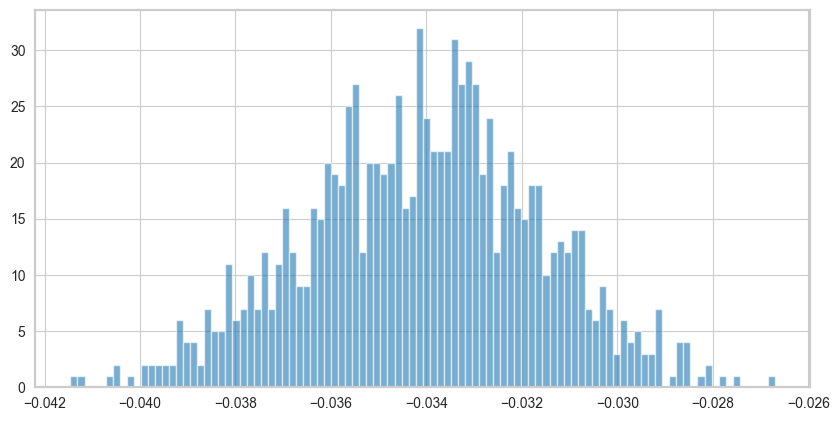

-0.034085207


In [18]:
plt_kwargs = {'bins': 100,
              'range': (-0.05, 0.05)}
plt.hist(pnl_before, bins=100, alpha=0.6)
plt.show()

print(np.mean(pnl_before))

## after learn

In [20]:
# model, losses = learn(model, env, steps=400, gaps=10)
model, losses = learn2(model, steps=200)

Loss=0.02175: 100%|██████████| 200/200 [00:25<00:00,  7.79it/s]


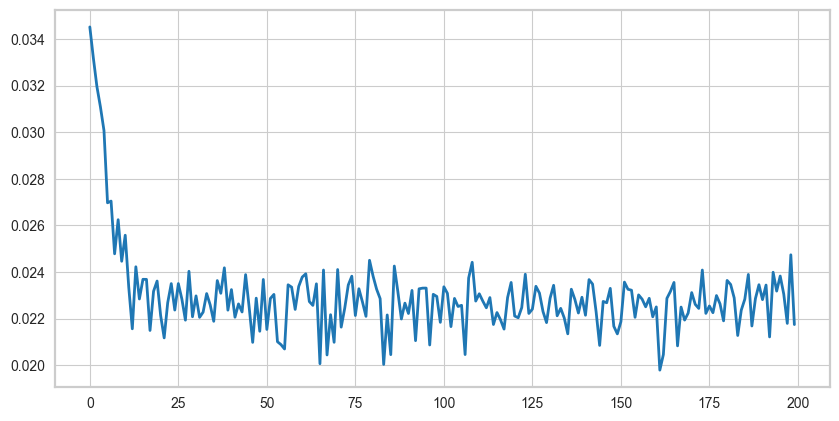

In [21]:
plt.plot(losses)

In [24]:
with th.no_grad():
    pnl_after = np.mean([to_numpy(compute_pnl(model, 1000)) for _ in range(30)], axis=0)

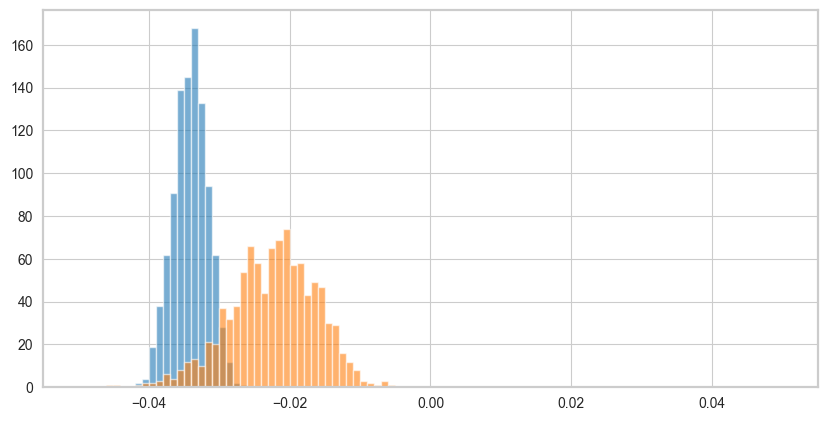

-0.034085207
-0.02238838


In [26]:
plt.hist(pnl_before, alpha=0.6, **plt_kwargs)
plt.hist(pnl_after, alpha=0.6, **plt_kwargs)
plt.show()

print(np.mean(pnl_before))
print(np.mean(pnl_after))